# Repro of 'Fair Conformal Predictions for Applications in Medical Imaging'

In [3]:
# Import dependencies

from src import platt
from src import uncertainty
from src import conformal
from src import distances
from src import metrics
from src import utils
import importlib
import collections
import itertools
import json
import os
import pathlib
import sys
import PIL
import scipy
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib.pyplot as plt

importlib.reload(metrics)
importlib.reload(platt)
importlib.reload(uncertainty)
importlib.reload(conformal)
importlib.reload(utils)
importlib.reload(distances)

# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
# plt.rcParams["font.family"] = "Times New Roman"
np.random.seed(0)

## Load metadata

In [25]:
label_csv = 'combined_data_fixed.csv'
skin_df = pd.read_csv(label_csv)
skin_df.head()

,image,age_approx,benign_malignant,diagnosis,patient_id,sex,id
0,ISIC_6006602.JPG,3,benign,atypical melanocytic proliferation,IP_3462372,female,0
1,ISIC_0282371.JPG,3,benign,atypical melanocytic proliferation,IP_6200159,female,1
2,ISIC_4201157.JPG,4,benign,atypical melanocytic proliferation,IP_9429205,male,2
3,ISIC_9286502.JPG,3,benign,atypical melanocytic proliferation,IP_9274667,female,3
4,ISIC_6009572.JPG,3,benign,atypical melanocytic proliferation,IP_9274667,female,4


## Create fig directory

In [26]:
save_dir = 'figures/'
fig_dir = pathlib.Path(save_dir)
fig_dir.mkdir(exist_ok=True)

## Plot class distribution 

In [27]:
# neo_df = skin_df.query('three_partition_label == "non-neoplastic"')
ben_df = skin_df.query('benign_malignant == "benign"')
mal_df = skin_df.query('benign_malignant == "malignant"')

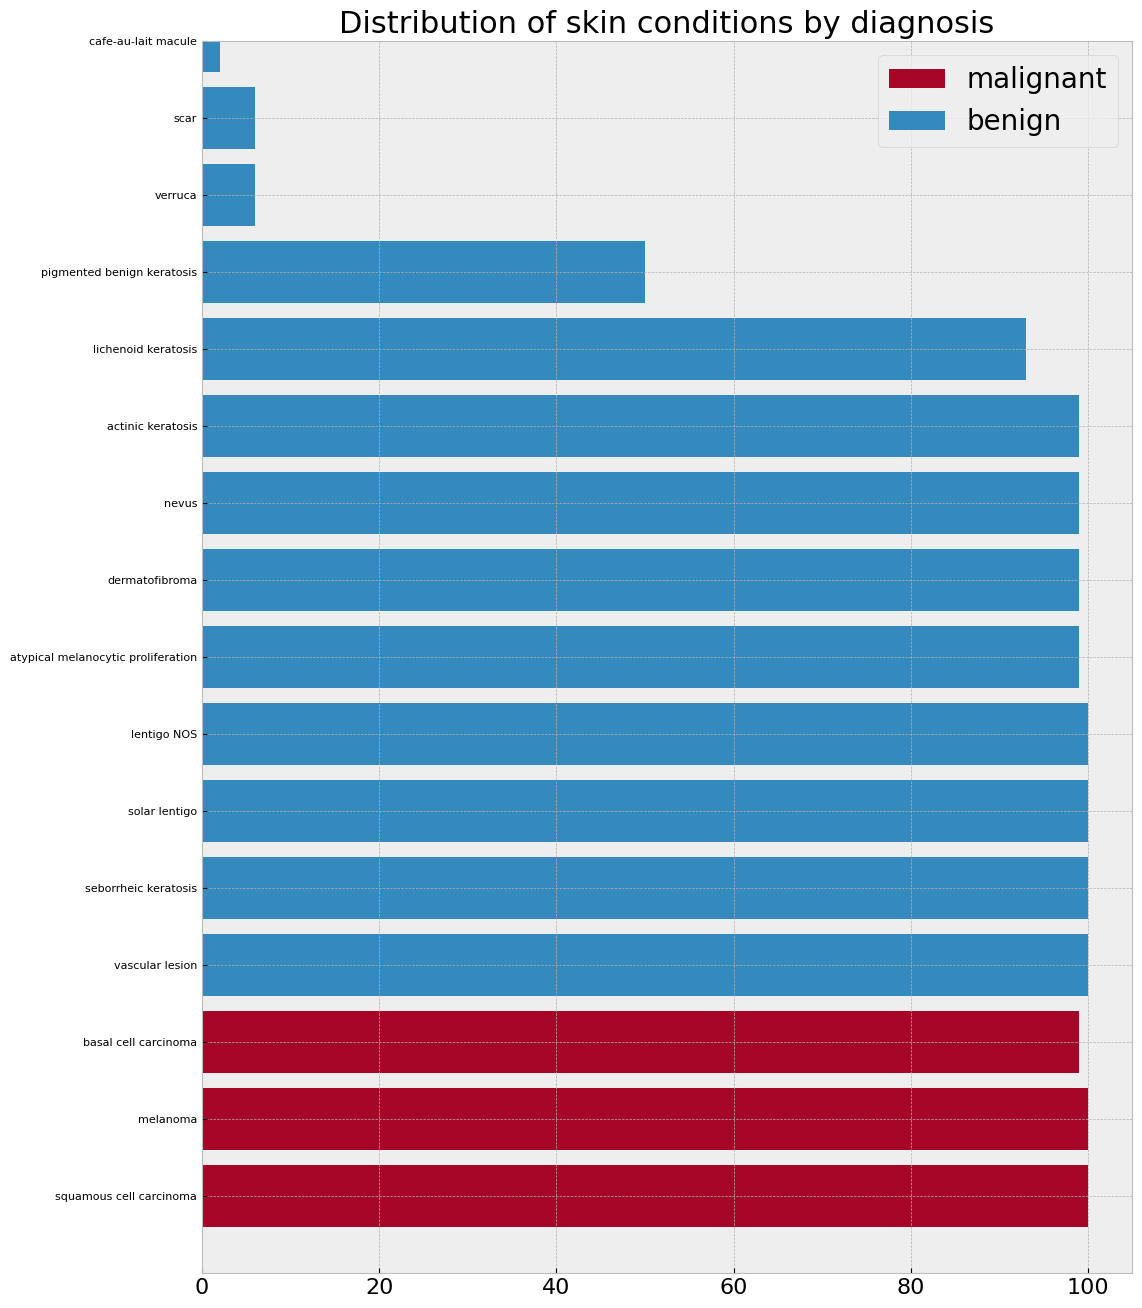

In [28]:
plt.figure(figsize=(12, 16))
plt.title('Distribution of skin conditions by diagnosis', fontsize=22)
plt.ylim(-1, 15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=8)
plt.barh(*list(zip(*mal_df.diagnosis.value_counts().items())), color='C1', label='malignant')
plt.barh(*list(zip(*ben_df.diagnosis.value_counts().items())), color='C0', label='benign')
plt.legend(fontsize=20)
plt.savefig(fig_dir / 'bar-class-distribution.png')
plt.show()

## benign VS malignant per age group

In [33]:
group_0 = skin_df.query('age_approx == 0').benign_malignant.value_counts()
group_1 = skin_df.query('age_approx == 1').benign_malignant.value_counts()
group_2 = skin_df.query('age_approx == 2').benign_malignant.value_counts()
group_3 = skin_df.query('age_approx == 3').benign_malignant.value_counts()
group_4 = skin_df.query('age_approx == 4').benign_malignant.value_counts()
group_5 = skin_df.query('age_approx == 5').benign_malignant.value_counts()
skin_type_all = skin_df.benign_malignant.value_counts()

def prevalence(group):
    total = group.sum()
    ben = group['benign'] / total
    mal = group['malignant'] / total
    print(f'Benign\t\t{ben:.2%}')
    print(f'Malignant\t{mal:.2%}')
    print(f'Count\t\t{total:.2f}')
    print()
    
print('30yrs'.center(20, '-')); prevalence(group_0)
print('40yrs'.center(20, '-')); prevalence(group_1)
print('50yrs'.center(20, '-')); prevalence(group_2)
print('60yrs'.center(20, '-')); prevalence(group_3)
print('70yrs'.center(20, '-')); prevalence(group_4)
print('80yrs'.center(20, '-')); prevalence(group_5)
print('All'.center(20, '-')); prevalence(skin_type_all)

-------30yrs--------
Benign		89.29%
Malignant	10.71%
Count		112.00

-------40yrs--------
Benign		90.71%
Malignant	9.29%
Count		140.00

-------50yrs--------
Benign		85.45%
Malignant	14.55%
Count		213.00

-------60yrs--------
Benign		76.80%
Malignant	23.20%
Count		362.00

-------70yrs--------
Benign		67.85%
Malignant	32.15%
Count		311.00

-------80yrs--------
Benign		48.25%
Malignant	51.75%
Count		114.00

--------All---------
Benign		76.12%
Malignant	23.88%
Count		1252.00



## Model

* Resnet34 models initialized with different random seed (5 runs)
* Train on isic dataset for skin lesion dianosis (14 classes)
* Monte Carlo-dropout for epistemic uncertainty (x 30)

In [42]:
def parse_result(values):
    ret = {}
    image = values['meta']['image']
    label = values['meta']['label']
    subgroup = values['meta']['subgroup']
    ret['image'] = image
    ret['label'] = label
    ret['subgroup'] = subgroup
    
    #  group mc by class
    class_pred = collections.defaultdict(list)
    for k, v in values.items():
        if k.startswith('mc_'):
            for i, x in enumerate(v[0]):
                class_pred[i].append(x)
                
    for c, pred in class_pred.items():
        ret[f'pred_{c}'] = pred
        
    return ret

In [43]:
run_path = 'run_2023_may_08_17_59_24/'
valid_paths = dict()
test_paths = dict()
for i in range(2):
    valid_p = pathlib.Path(run_path + 'seed_' + str(i) + '/' ).glob('valid-res*')
    for v in valid_p:
        valid_paths['seed_' + str(i)] = v
    test_p = pathlib.Path(run_path + 'seed_' + str(i) + '/' ).glob('test-res*')
    for t in test_p:
        test_paths['seed_' + str(i)] = t

label_map = dict(enumerate(sorted(skin_df.diagnosis.unique())))
reversed_label_map = dict(zip(label_map.values(), label_map.keys()))

valid_dfs = {k: pd.DataFrame(list(map(parse_result, json.load(open(v)).values()))) for k, v in valid_paths.items()}
test_dfs = {k: pd.DataFrame(list(map(parse_result, json.load(open(v)).values()))) for k, v in test_paths.items()}

accuracy = []
for df in test_dfs.values():
    correct = 0
    for i, row in df[['label'] + [c for c in df.columns if c.startswith('pred_')]].iterrows():
        label = row.label
        pred = np.argmax([c[0] for c in row[1:]])
        if label == pred: correct += 1
    accuracy.append(correct / len(df))

In [39]:
valid_dfs = {k: pd.DataFrame(list(map(parse_result, json.load(open(v)).values()))) for k, v in valid_paths.items()}
test_dfs = {k: pd.DataFrame(list(map(parse_result, json.load(open(v)).values()))) for k, v in test_paths.items()}

In [40]:
accuracy = []
for df in test_dfs.values():
    correct = 0
    for i, row in df[['label'] + [c for c in df.columns if c.startswith('pred_')]].iterrows():
        label = row.label
        pred = np.argmax([c[0] for c in row[1:]])
        if label == pred: correct += 1
    accuracy.append(correct / len(df))

In [44]:
print(f'average accuracy {np.mean(accuracy):.2f} +/- {np.std(accuracy):.2f}')

average accuracy 0.14 +/- 0.01


In [46]:
# number of  classses
class_count = 16

def get_logits(row):
    return np.array([row[f'pred_{c}'][0] for c in range(class_count)]).tolist()
    
for k, df in valid_dfs.items():
    df['logits'] = df.apply(lambda row: get_logits(row), axis=1)

for k, df in test_dfs.items():
    df['logits'] = df.apply(lambda row: get_logits(row), axis=1)

### Get score on platt scaling

In [47]:
for k, df in valid_dfs.items():
    # learn temperature weight using validation set
    T = platt.get_platt_scaling(df.label.values, [x for x in df.logits.values])
    valid_logits = torch.tensor([x for x in df.logits.values]) 
    df['scores'] = torch.softmax(valid_logits / T, axis=1).tolist()
   
    # apply on test set
    test_df = test_dfs[k]
    test_logits = torch.tensor([x for x in test_df.logits.values]) 
    test_df['scores'] = torch.softmax(test_logits / T, axis=1).tolist()

### Create age group list

In [49]:
A = list(reversed(range(len(df.subgroup.unique()))))
A 


[5, 4, 3, 2, 1, 0]

### Miscoverage levels $\alpha$

<!-- $$1 - \alpha \leq P(\hat{Y}_{n+1} \in \mathcal{C}(X_{n+1})) \leq 1 - \alpha + \frac{1}{n + 1}$$ -->

In [82]:
ALPHAS = [round(x, 2) for x in np.arange(0.05, 0.55, 0.05)]
print(ALPHAS)

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]


### Conformal metrics

1. __Marginal coverage__ -- probability that the true class is contained within prediction set 
2. __Marginal cardinality__ - expected prediction set size
3. __Subgroup coverage__  - marginal coverage per subgroup 
4. __Subgroup cardinality__  - marginal cardinality per subgroup 

In [79]:
def get_coverage(labels: list, prediction_sets: list) -> float:
    k = len(labels)
    assert k
    correct = 0
    for label, pred in zip(labels, prediction_sets):
        correct += 1 if label in pred else 0
    return correct / k

def get_cardinality(prediction_sets: list) -> float:
    k = len(prediction_sets)
    assert k
    return sum([len(x) for x in prediction_sets]) / k

def get_subgroup_coverage(df, pred_col, label_col='label', subgroup_col='subgroup', subgroups=A) -> dict:
    res = {}
    for a in subgroups:
        sub_df = df[df[subgroup_col] == a]
        res[a] = get_coverage(
            sub_df[label_col].values.tolist(),
            sub_df[pred_col].values.tolist(),
        )
    return res

def get_subgroup_cardinality(df, pred_col, subgroup_col='subgroup', subgroups=A) -> dict:
    res = {}
    for a in subgroups:
        sub_df = df[df[subgroup_col] == a]
        res[a] = get_cardinality(sub_df[pred_col].values.tolist())
    return res

### Helper functions

In [53]:
def aggregate_coverage(dfs, prefix, alphas=ALPHAS):
    # Collate prediction sets for all runs at different levels of coverage
    coverage_by_alpha = collections.defaultdict(list)
    for seed, df in dfs.items():
        for alpha in alphas:
            labels = [x for x in dfs[seed].label.values]
            prediction_sets = [x for x in dfs[seed][f'{prefix}_{alpha}'].values]
            coverage_by_alpha[alpha].append(get_coverage(labels, prediction_sets))
    
    coverage_by_alpha = dict(coverage_by_alpha)
    alpha, coverage = zip(*coverage_by_alpha.items())
    coverage = np.array(coverage)
    coverage_mean = coverage.mean(1)
    coverage_std = coverage.std(1)
    return alpha, coverage_mean, coverage_std
    
def aggregate_cardinality(dfs, prefix, alphas=ALPHAS):
    cardinality_by_alpha = collections.defaultdict(list)

    for seed, df in dfs.items():
        for alpha in ALPHAS:
            labels = [x for x in dfs[seed].label.values]
            prediction_sets = [x for x in dfs[seed][f'{prefix}_{alpha}'].values]
            cardinality_by_alpha[alpha].append(get_cardinality(prediction_sets))

    cardinality_by_alpha = dict(cardinality_by_alpha)
    alpha, cardinality = zip(*cardinality_by_alpha.items())
    cardinality = np.array(cardinality)
    cardinality_mean = cardinality.mean(1)
    cardinality_std = cardinality.std(1)
    return alpha, cardinality_mean, cardinality_std

In [54]:
# Helper functions for subgroup
def aggregate_coverage_subgroup(dfs, prefix, alphas=ALPHAS):
    # Collate prediction sets for all runs at different levels of coverage
    subgroup_coverage_by_alpha = collections.defaultdict(dict)
    for seed, df in dfs.items():
        for alpha in alphas:
            for sub, cov in get_subgroup_coverage(df, f'{prefix}_{alpha}').items():
                if sub in subgroup_coverage_by_alpha[alpha]:
                    subgroup_coverage_by_alpha[alpha][sub] += [cov]
                else:
                    subgroup_coverage_by_alpha[alpha][sub] = [cov]
    
    alpha, subgroup_cov = zip(*subgroup_coverage_by_alpha.items())

    coverage_mean = collections.defaultdict(list)
    coverage_std = collections.defaultdict(list)

    for res in subgroup_cov:
        for group, cov in res.items():
            cov = np.array(cov)
            coverage_mean[group].append(cov.mean())
            coverage_std[group].append(cov.std())

    coverage_mean = dict(coverage_mean)
    coverage_std = dict(coverage_std)
    
    return alpha, coverage_mean, coverage_std

    
def aggregate_cardinality_subgroup(dfs, prefix, alphas=ALPHAS):
    subgroup_cardinality_by_alpha = collections.defaultdict(dict)

    for seed, df in dfs.items():
        for alpha in ALPHAS:
            for sub, card in get_subgroup_cardinality(df, f'{prefix}_{alpha}').items():
                if sub in subgroup_cardinality_by_alpha[alpha]:
                    subgroup_cardinality_by_alpha[alpha][sub] += [card]
                else:
                    subgroup_cardinality_by_alpha[alpha][sub] = [card]

    subgroup_cardinality_by_alpha = dict(subgroup_cardinality_by_alpha)
    alpha, cardinality = zip(*subgroup_cardinality_by_alpha.items())
    
    cardinality_mean = collections.defaultdict(list)
    cardinality_std = collections.defaultdict(list)

    for res in cardinality:
        for group, card in res.items():
            card = np.array(card)
            cardinality_mean[group].append(card.mean())
            cardinality_std[group].append(card.std())

    cardinality_mean = dict(cardinality_mean)
    cardinality_std = dict(cardinality_std)
    
    return alpha, cardinality_mean, cardinality_std

### Naive prediction sets

* Platt scaling on logits
* Form set by adding elements from sorted softmax scores until cumulative sum exceeds $1 - \alpha$

In [55]:
naive_qhat = {}
for k, df in valid_dfs.items():
    scores = [x for x in df.scores.values]
    labels = [x for x in df.label.values]
    s = torch.tensor([1 - s[l] for s, l in zip(scores, labels)])
    n = len(df)
    for alpha in ALPHAS:
        p = np.ceil((n + 1) * (1 - alpha)) / n
        naive_qhat[alpha] = torch.quantile(s, p).item()
        
for k, df in test_dfs.items():
    scores = np.array([x for x in df.scores.values])
    for alpha in ALPHAS:
        df[f'naive_{alpha}'] = [np.nonzero(s > (1 - naive_qhat[alpha]))[0] for s in scores]

In [56]:
columns = [f'naive_{alpha}' for alpha in ALPHAS]
test_dfs['seed_0'][columns].head()

,naive_0.05,naive_0.1,naive_0.15,naive_0.2,naive_0.25,naive_0.3,naive_0.35,naive_0.4,naive_0.45,naive_0.5
0,"[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14]","[0, 1, 2, 4, 5, 6, 7, 8, 11, 12, 13, 14]","[1, 2, 4, 5, 6, 7, 11, 13, 14]","[1, 2, 4, 5, 6, 7, 11, 13]","[1, 2, 4, 5, 6, 7, 11, 13]","[1, 2, 4, 5, 6, 7, 11, 13]","[1, 2, 4, 5, 6, 7, 11, 13]","[1, 2, 4, 5, 7, 11, 13]","[1, 2, 4, 5, 7, 11, 13]","[1, 2, 4, 5, 11, 13]"
1,"[0, 1, 4, 5, 6, 7, 8, 11, 12, 13, 14]","[0, 4, 5, 6, 7, 8, 11, 12, 13, 14]","[0, 4, 5, 7, 8, 11, 12, 13, 14]","[4, 5, 7, 8, 11, 12, 13]","[4, 5, 7, 8, 11, 12, 13]","[4, 5, 7, 8, 11, 12, 13]","[4, 5, 7, 8, 12, 13]","[4, 5, 7, 8, 12, 13]","[4, 5, 7, 8, 12, 13]","[4, 5, 7, 8, 12, 13]"
2,"[2, 7, 8, 9, 11, 13, 14]","[2, 7, 8, 9, 11, 13, 14]","[2, 7, 9, 11, 13, 14]","[2, 7, 9, 11, 13, 14]","[2, 7, 9, 11, 13, 14]","[2, 7, 9, 11, 13, 14]","[2, 7, 9, 11, 13, 14]","[2, 7, 9, 11, 13, 14]","[2, 7, 9, 11, 13, 14]","[2, 7, 9, 11, 13, 14]"
3,"[0, 1, 2, 4, 5, 7, 8, 11, 12, 13, 14]","[1, 2, 4, 5, 7, 8, 12, 13, 14]","[1, 2, 4, 7, 8, 12, 13, 14]","[1, 2, 4, 7, 8, 13, 14]","[1, 4, 7, 8, 14]","[1, 7, 8, 14]","[1, 7, 8]","[1, 7, 8]","[1, 7, 8]","[1, 7, 8]"
4,"[0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12]","[0, 1, 2, 4, 5, 6, 8, 11, 12]","[0, 1, 2, 4, 5, 6, 11, 12]","[0, 1, 2, 4, 5, 6, 11, 12]","[0, 1, 2, 4, 5, 6, 11, 12]","[0, 1, 4, 5, 6, 11, 12]","[0, 1, 4, 5, 6, 12]","[0, 4, 5, 6, 12]","[0, 4, 5, 6, 12]","[0, 4, 5, 12]"


In [57]:
alpha, naive_coverage_mean, naive_coverage_std = aggregate_coverage(test_dfs, prefix='naive')
alpha, naive_cardinality_mean, naive_cardinality_std = aggregate_cardinality(test_dfs, prefix='naive')

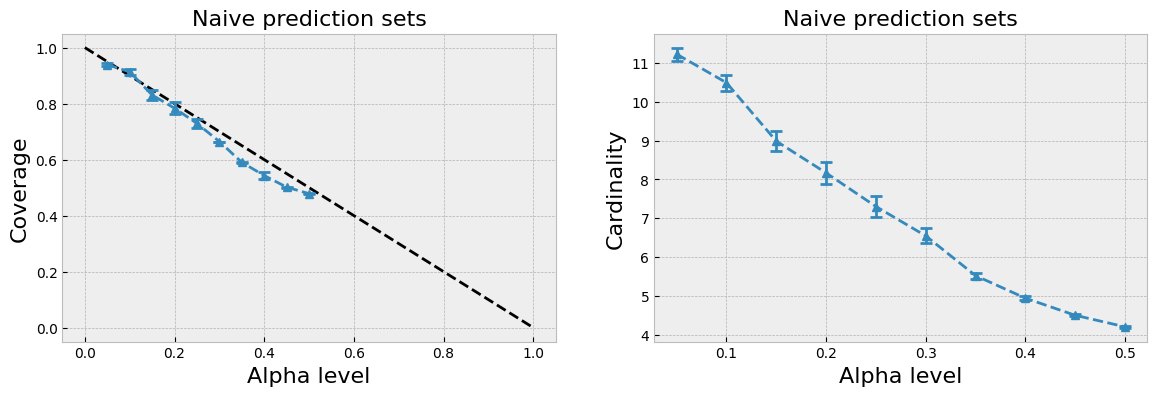

In [58]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].errorbar(
    alpha, naive_coverage_mean, yerr=naive_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].set_title('Naive prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, naive_cardinality_mean, yerr=naive_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('Naive prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Adaptive prediction set (APS)

* Calibration set for correct marginal coverage

In [59]:
importlib.reload(conformal)

<module 'src.conformal' from '/Users/guandali/Desktop/CS_598/src/conformal.py'>

In [60]:
# calibrate 
aps_qhat = collections.defaultdict(dict)
for k, df in valid_dfs.items():
    scores = [x for x in df.scores.values]
    labels = [x for x in df.label.values]
    for alpha in ALPHAS:
        qhat = conformal.get_q_hat(scores, labels, alpha=alpha)
        aps_qhat[k][alpha] = qhat.item()
        
aps_qhat = dict(aps_qhat)

In [61]:
print(aps_qhat['seed_0'][0.05])

0.9453608989715576


In [62]:
# inference
for k, df in test_dfs.items():
    scores = [x for x in df.scores.values]
    for alpha in ALPHAS:
        qhat = aps_qhat[k][alpha]
        df[f'aps_{alpha}'] = conformal.conformal_inference(scores, qhat)

In [63]:
columns = [f'aps_{alpha}' for alpha in ALPHAS]
test_dfs['seed_0'][columns].head()

,aps_0.05,aps_0.1,aps_0.15,aps_0.2,aps_0.25,aps_0.3,aps_0.35,aps_0.4,aps_0.45,aps_0.5
0,"[1, 5, 11, 13, 4, 2, 7, 6, 14, 12, 8, 0, 9]","[1, 5, 11, 13, 4, 2, 7, 6, 14, 12, 8, 0]","[1, 5, 11, 13, 4, 2, 7, 6, 14, 12, 8]","[1, 5, 11, 13, 4, 2, 7, 6, 14, 12]","[1, 5, 11, 13, 4, 2, 7, 6, 14, 12]","[1, 5, 11, 13, 4, 2, 7, 6, 14]","[1, 5, 11, 13, 4, 2, 7, 6]","[1, 5, 11, 13, 4, 2, 7, 6]","[1, 5, 11, 13, 4, 2, 7]","[1, 5, 11, 13, 4, 2, 7]"
1,"[13, 7, 4, 5, 12, 8, 11, 0, 14, 6, 1, 10]","[13, 7, 4, 5, 12, 8, 11, 0, 14, 6, 1]","[13, 7, 4, 5, 12, 8, 11, 0, 14, 6]","[13, 7, 4, 5, 12, 8, 11, 0, 14, 6]","[13, 7, 4, 5, 12, 8, 11, 0, 14]","[13, 7, 4, 5, 12, 8, 11, 0]","[13, 7, 4, 5, 12, 8, 11]","[13, 7, 4, 5, 12, 8, 11]","[13, 7, 4, 5, 12, 8]","[13, 7, 4, 5, 12, 8]"
2,"[14, 11, 2, 9, 13, 7, 8, 0, 4]","[14, 11, 2, 9, 13, 7, 8, 0]","[14, 11, 2, 9, 13, 7, 8]","[14, 11, 2, 9, 13, 7]","[14, 11, 2, 9, 13, 7]","[14, 11, 2, 9, 13, 7]","[14, 11, 2, 9, 13]","[14, 11, 2, 9, 13]","[14, 11, 2, 9, 13]","[14, 11, 2, 9]"
3,"[7, 1, 8, 14, 4, 13, 2, 12, 5, 11, 0, 6]","[7, 1, 8, 14, 4, 13, 2, 12, 5, 11, 0]","[7, 1, 8, 14, 4, 13, 2, 12, 5, 11]","[7, 1, 8, 14, 4, 13, 2, 12, 5, 11]","[7, 1, 8, 14, 4, 13, 2, 12, 5]","[7, 1, 8, 14, 4, 13, 2, 12]","[7, 1, 8, 14, 4, 13, 2]","[7, 1, 8, 14, 4, 13]","[7, 1, 8, 14, 4, 13]","[7, 1, 8, 14, 4]"
4,"[4, 5, 12, 0, 6, 1, 11, 2, 8, 9, 7, 14]","[4, 5, 12, 0, 6, 1, 11, 2, 8, 9, 7]","[4, 5, 12, 0, 6, 1, 11, 2, 8, 9]","[4, 5, 12, 0, 6, 1, 11, 2, 8]","[4, 5, 12, 0, 6, 1, 11, 2]","[4, 5, 12, 0, 6, 1, 11, 2]","[4, 5, 12, 0, 6, 1, 11]","[4, 5, 12, 0, 6, 1, 11]","[4, 5, 12, 0, 6, 1]","[4, 5, 12, 0, 6]"


In [64]:
alpha, aps_coverage_mean, aps_coverage_std = aggregate_coverage(test_dfs, prefix='aps')
alpha, aps_cardinality_mean, aps_cardinality_std = aggregate_cardinality(test_dfs, prefix='aps')

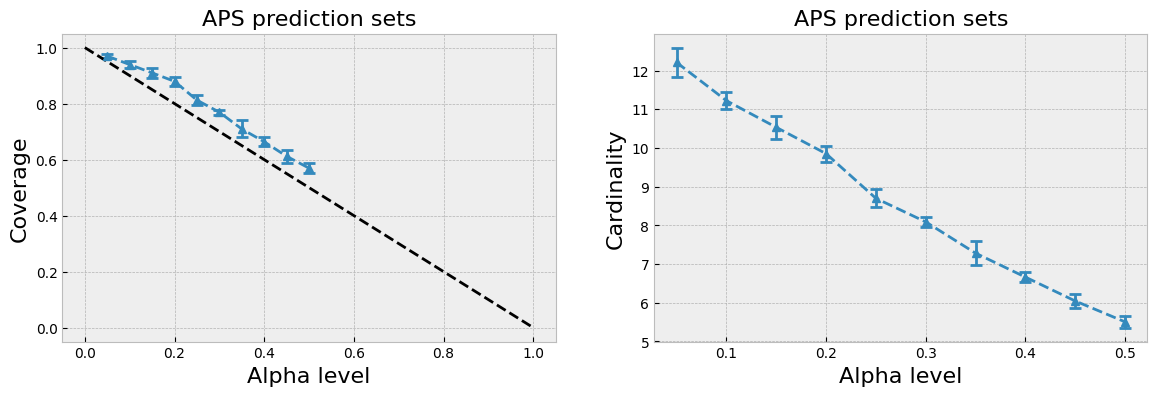

In [65]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, aps_coverage_mean, yerr=aps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('APS prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, aps_cardinality_mean, yerr=aps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('APS prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Group APS (GAPS)

Conformal calibration for each subgroup 

In [101]:
importlib.reload(conformal)

<module 'src.conformal' from '/Users/guandali/Desktop/CS_598/src/conformal.py'>

In [73]:
# calibrate 
gaps_qhat = collections.defaultdict(dict)

for k, df in valid_dfs.items():
    alpha_qhat = collections.defaultdict(dict)
    for alpha in ALPHAS:
        group_qhat = collections.defaultdict(dict)
        for a in A:
            group_df = df[df.subgroup == a]
            scores = [x for x in group_df.scores.values]
            labels = [x for x in group_df.label.values]
            qhat = conformal.get_q_hat(scores, labels, alpha=alpha)
            gaps_qhat[k][alpha] = qhat.item()

            group_qhat[a] = qhat
            
        alpha_qhat[alpha] = dict(group_qhat)
        
    gaps_qhat[k] = dict(alpha_qhat)

gaps_qhat = dict(gaps_qhat)

In [74]:
# inference

for k, df in test_dfs.items():
    temp = []
    scores = np.array([x for x in df.scores.values])
    index, ordered, cumsum = conformal.sort_sum(scores)
    for a in A:
        group_df = df[df.subgroup == a].copy()
        
        # APS
        scores = [x for x in group_df.scores.values]
        for alpha in ALPHAS:
            qhat = gaps_qhat[k][alpha][a]
            group_df[f'gaps_{alpha}'] = conformal.conformal_inference(scores, qhat)
        
        temp.append(group_df)
    test_dfs[k] = pd.concat(temp)

In [75]:
# columns = [f'gaps_{alpha}' for alpha in ALPHAS]
columns = [f'gaps_{alpha}' for alpha in ALPHAS]
test_dfs['seed_0'][columns].head()

,gaps_0.15,gaps_0.2,gaps_0.25,gaps_0.3,gaps_0.35,gaps_0.4,gaps_0.45,gaps_0.5
20,"[4, 0, 6, 1, 5, 8, 12, 2, 11, 14]","[4, 0, 6, 1, 5, 8, 12, 2, 11, 14]","[4, 0, 6, 1, 5, 8, 12, 2, 11]","[4, 0, 6, 1, 5, 8, 12, 2, 11]","[4, 0, 6, 1, 5, 8, 12, 2, 11]","[4, 0, 6, 1, 5, 8, 12, 2]","[4, 0, 6, 1, 5, 8, 12, 2]","[4, 0, 6, 1, 5, 8, 12]"
24,"[12, 6, 0, 1, 5, 11, 13, 4, 7]","[12, 6, 0, 1, 5, 11, 13, 4, 7]","[12, 6, 0, 1, 5, 11, 13, 4]","[12, 6, 0, 1, 5, 11, 13, 4]","[12, 6, 0, 1, 5, 11, 13, 4]","[12, 6, 0, 1, 5, 11, 13]","[12, 6, 0, 1, 5, 11, 13]","[12, 6, 0, 1, 5, 11]"
32,"[1, 8, 12, 11, 14, 5, 4, 7, 9, 15, 6]","[1, 8, 12, 11, 14, 5, 4, 7, 9, 15, 6]","[1, 8, 12, 11, 14, 5, 4, 7, 9, 15]","[1, 8, 12, 11, 14, 5, 4, 7, 9, 15]","[1, 8, 12, 11, 14, 5, 4, 7, 9, 15]","[1, 8, 12, 11, 14, 5, 4, 7]","[1, 8, 12, 11, 14, 5, 4, 7]","[1, 8, 12, 11, 14, 5, 4]"
43,"[5, 11, 4, 0, 1, 12, 6, 8, 13, 7, 2]","[5, 11, 4, 0, 1, 12, 6, 8, 13, 7, 2]","[5, 11, 4, 0, 1, 12, 6, 8, 13, 7]","[5, 11, 4, 0, 1, 12, 6, 8, 13, 7]","[5, 11, 4, 0, 1, 12, 6, 8, 13, 7]","[5, 11, 4, 0, 1, 12, 6, 8, 13]","[5, 11, 4, 0, 1, 12, 6, 8, 13]","[5, 11, 4, 0, 1, 12, 6, 8]"
57,"[5, 11, 0, 4, 12, 6, 13, 2, 7, 8]","[5, 11, 0, 4, 12, 6, 13, 2, 7, 8]","[5, 11, 0, 4, 12, 6, 13, 2, 7]","[5, 11, 0, 4, 12, 6, 13, 2, 7]","[5, 11, 0, 4, 12, 6, 13, 2, 7]","[5, 11, 0, 4, 12, 6, 13, 2]","[5, 11, 0, 4, 12, 6, 13, 2]","[5, 11, 0, 4, 12, 6, 13]"


In [80]:
alpha, gaps_coverage_mean, gaps_coverage_std = aggregate_coverage(test_dfs, prefix='gaps', alphas=ALPHAS)
alpha, gaps_cardinality_mean, gaps_cardinality_std = aggregate_cardinality(test_dfs, prefix='gaps', alphas=ALPHAS)

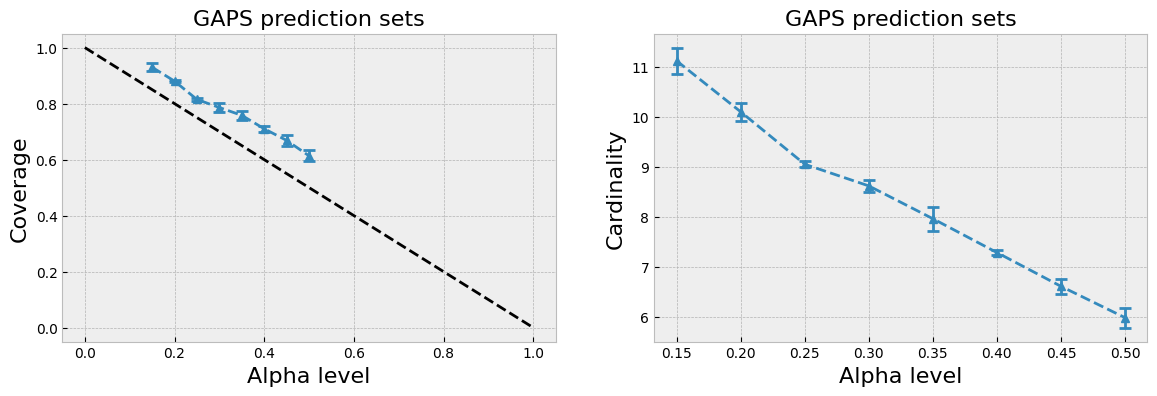

In [81]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, gaps_coverage_mean, yerr=gaps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('GAPS prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, gaps_cardinality_mean, yerr=gaps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('GAPS prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Regularized adaptive prediction set (RAPS)

* Calibration set for correct marginal coverage
* Parameterized regulaization penality $\lambda$ and $K$

In [83]:
K_REG = 0
LAMBDA = 1e-4

penalty = np.zeros((1, C))
penalty[:, K_REG:] += LAMBDA

# randomized
RAND = True

# allow zero sets
ZERO = True  

In [98]:
# calibrate 
raps_qhat = collections.defaultdict(dict)
for k, df in valid_dfs.items():
    scores = np.array([x for x in df.scores.values])
    labels = np.array([x for x in df.label.values])
    index, ordered, cumsum = conformal.sort_sum(scores)
    for alpha in ALPHAS:
        qhat = conformal.raps_calibrate(
            scores, labels, index, ordered, cumsum,
            penalty, randomized=RAND, allow_zero_sets=ZERO, alpha=alpha
        )
        raps_qhat[k][alpha] = qhat
        
raps_qhat = dict(raps_qhat)

In [99]:
print(raps_qhat['seed_0'][0.05])

0.9218467545992034


In [102]:
# inference
for k, df in test_dfs.items():
    scores = np.array([x for x in df.scores.values])
    index, ordered, cumsum = conformal.sort_sum(scores)
    for alpha in ALPHAS:
        qhat = raps_qhat[k][alpha]
        df[f'raps_{alpha}'] = conformal.raps_predict(
            scores, qhat, index, ordered, cumsum, 
            penalty, randomized=RAND, allow_zero_sets=ZERO,
        )

In [103]:
columns = [f'raps_{alpha}' for alpha in ALPHAS]
test_dfs['seed_0'][columns].head()

,raps_0.05,raps_0.1,raps_0.15,raps_0.2,raps_0.25,raps_0.3,raps_0.35,raps_0.4,raps_0.45,raps_0.5
20,"[4, 0, 6, 1, 5, 8, 12, 2, 11, 14, 13]","[4, 0, 6, 1, 5, 8, 12, 2, 11, 14, 13]","[4, 0, 6, 1, 5, 8, 12, 2, 11, 14]","[4, 0, 6, 1, 5, 8, 12, 2, 11]","[4, 0, 6, 1, 5, 8, 12, 2]","[4, 0, 6, 1, 5, 8, 12, 2]","[4, 0, 6, 1, 5, 8, 12]","[4, 0, 6, 1, 5, 8]","[4, 0, 6, 1, 5, 8]","[4, 0, 6, 1, 5]"
24,"[12, 6, 0, 1, 5, 11, 13, 4, 7, 2]","[12, 6, 0, 1, 5, 11, 13, 4, 7, 2]","[12, 6, 0, 1, 5, 11, 13, 4, 7]","[12, 6, 0, 1, 5, 11, 13, 4]","[12, 6, 0, 1, 5, 11, 13]","[12, 6, 0, 1, 5, 11, 13]","[12, 6, 0, 1, 5, 11]","[12, 6, 0, 1, 5]","[12, 6, 0, 1, 5]","[12, 6, 0, 1]"
32,"[1, 8, 12, 11, 14, 5, 4, 7, 9, 15, 6, 13]","[1, 8, 12, 11, 14, 5, 4, 7, 9, 15, 6]","[1, 8, 12, 11, 14, 5, 4, 7, 9, 15]","[1, 8, 12, 11, 14, 5, 4, 7, 9, 15]","[1, 8, 12, 11, 14, 5, 4, 7]","[1, 8, 12, 11, 14, 5, 4, 7]","[1, 8, 12, 11, 14, 5, 4]","[1, 8, 12, 11, 14, 5]","[1, 8, 12, 11, 14]","[1, 8, 12, 11]"
43,"[5, 11, 4, 0, 1, 12, 6, 8, 13, 7, 2, 9]","[5, 11, 4, 0, 1, 12, 6, 8, 13, 7, 2]","[5, 11, 4, 0, 1, 12, 6, 8, 13, 7]","[5, 11, 4, 0, 1, 12, 6, 8, 13, 7]","[5, 11, 4, 0, 1, 12, 6, 8, 13]","[5, 11, 4, 0, 1, 12, 6, 8]","[5, 11, 4, 0, 1, 12, 6, 8]","[5, 11, 4, 0, 1, 12, 6]","[5, 11, 4, 0, 1, 12]","[5, 11, 4, 0, 1, 12]"
57,"[5, 11, 0, 4, 12, 6, 13, 2, 7, 8, 1]","[5, 11, 0, 4, 12, 6, 13, 2, 7, 8, 1]","[5, 11, 0, 4, 12, 6, 13, 2, 7, 8]","[5, 11, 0, 4, 12, 6, 13, 2, 7]","[5, 11, 0, 4, 12, 6, 13, 2]","[5, 11, 0, 4, 12, 6, 13, 2]","[5, 11, 0, 4, 12, 6, 13]","[5, 11, 0, 4, 12, 6]","[5, 11, 0, 4, 12, 6]","[5, 11, 0, 4, 12]"


In [104]:
alpha, raps_coverage_mean, raps_coverage_std = aggregate_coverage(test_dfs, prefix='raps')
alpha, raps_cardinality_mean, raps_cardinality_std = aggregate_cardinality(test_dfs, prefix='raps')

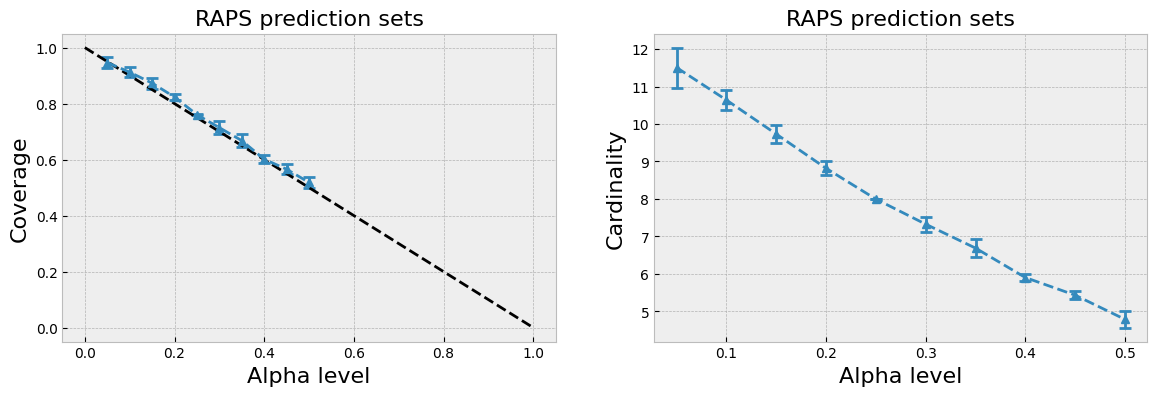

In [105]:
fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, raps_coverage_mean, yerr=raps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('RAPS prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, raps_cardinality_mean, yerr=raps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('RAPS prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Group RAPS (GRAPS)

In [138]:
# calibrate 
graps_qhat = collections.defaultdict(dict)

for k, df in valid_dfs.items():
    alpha_qhat = collections.defaultdict(dict)
    for alpha in ALPHAS:
        group_qhat = collections.defaultdict(dict)
        for a in A:
            group_df = df[df.subgroup == a]
            
            scores = np.array([x for x in group_df.scores.values])
            labels = np.array([x for x in group_df.label.values])
            index, ordered, cumsum = conformal.sort_sum(scores)
            qhat = conformal.raps_calibrate(
                scores, labels, index, ordered, cumsum,
                penalty, randomized=RAND, allow_zero_sets=ZERO, alpha=alpha
            )
            
            group_qhat[a] = qhat
            
        alpha_qhat[alpha] = dict(group_qhat)
        
    graps_qhat[k] = dict(alpha_qhat)

graps_qhat = dict(graps_qhat)


In [139]:
# inference

for k, df in test_dfs.items():
    temp = []
    scores = np.array([x for x in df.scores.values])
    index, ordered, cumsum = conformal.sort_sum(scores)
    for a in A:
        group_df = df[df.subgroup == a].copy()
        
        # RAPS
        scores = np.array([x for x in group_df.scores.values])
        for alpha in ALPHAS:
            qhat = graps_qhat[k][alpha][a]
            index, ordered, cumsum = conformal.sort_sum(scores)
            group_df[f'graps_{alpha}'] = conformal.raps_predict(
                scores, qhat.item(), index, ordered, cumsum, 
                penalty, randomized=RAND, allow_zero_sets=ZERO,
            )
            
        temp.append(group_df)
    test_dfs[k] = pd.concat(temp)

In [140]:
columns = [f'graps_{alpha}' for alpha in ALPHAS]
test_dfs['seed_0'][columns].head()

,graps_0.05,graps_0.1,graps_0.15,graps_0.2,graps_0.25,graps_0.3,graps_0.35,graps_0.4,graps_0.45,graps_0.5
20,"[4, 0, 6, 1, 5, 8, 12, 2, 11, 14]","[4, 0, 6, 1, 5, 8, 12, 2, 11]","[4, 0, 6, 1, 5, 8, 12, 2, 11]","[4, 0, 6, 1, 5, 8, 12, 2, 11]","[4, 0, 6, 1, 5, 8, 12, 2]","[4, 0, 6, 1, 5, 8, 12, 2]","[4, 0, 6, 1, 5, 8, 12, 2]","[4, 0, 6, 1, 5, 8, 12, 2]","[4, 0, 6, 1, 5, 8, 12]","[4, 0, 6, 1, 5, 8]"
24,"[12, 6, 0, 1, 5, 11, 13, 4, 7]","[12, 6, 0, 1, 5, 11, 13, 4]","[12, 6, 0, 1, 5, 11, 13, 4]","[12, 6, 0, 1, 5, 11, 13, 4]","[12, 6, 0, 1, 5, 11, 13, 4]","[12, 6, 0, 1, 5, 11, 13]","[12, 6, 0, 1, 5, 11, 13]","[12, 6, 0, 1, 5, 11, 13]","[12, 6, 0, 1, 5, 11]","[12, 6, 0, 1, 5]"
32,"[1, 8, 12, 11, 14, 5, 4, 7, 9, 15, 6]","[1, 8, 12, 11, 14, 5, 4, 7, 9, 15]","[1, 8, 12, 11, 14, 5, 4, 7, 9]","[1, 8, 12, 11, 14, 5, 4, 7, 9]","[1, 8, 12, 11, 14, 5, 4, 7]","[1, 8, 12, 11, 14, 5, 4, 7]","[1, 8, 12, 11, 14, 5, 4, 7]","[1, 8, 12, 11, 14, 5, 4]","[1, 8, 12, 11, 14, 5]","[1, 8, 12, 11, 14]"
43,"[5, 11, 4, 0, 1, 12, 6, 8, 13, 7, 2]","[5, 11, 4, 0, 1, 12, 6, 8, 13, 7]","[5, 11, 4, 0, 1, 12, 6, 8, 13]","[5, 11, 4, 0, 1, 12, 6, 8, 13, 7]","[5, 11, 4, 0, 1, 12, 6, 8, 13]","[5, 11, 4, 0, 1, 12, 6, 8]","[5, 11, 4, 0, 1, 12, 6, 8]","[5, 11, 4, 0, 1, 12, 6, 8]","[5, 11, 4, 0, 1, 12, 6]","[5, 11, 4, 0, 1, 12, 6]"
57,"[5, 11, 0, 4, 12, 6, 13, 2, 7, 8]","[5, 11, 0, 4, 12, 6, 13, 2, 7]","[5, 11, 0, 4, 12, 6, 13, 2, 7]","[5, 11, 0, 4, 12, 6, 13, 2, 7]","[5, 11, 0, 4, 12, 6, 13, 2]","[5, 11, 0, 4, 12, 6, 13, 2]","[5, 11, 0, 4, 12, 6, 13, 2]","[5, 11, 0, 4, 12, 6, 13, 2]","[5, 11, 0, 4, 12, 6, 13]","[5, 11, 0, 4, 12, 6]"


In [141]:
alpha, graps_coverage_mean, graps_coverage_std = aggregate_coverage(test_dfs, prefix='graps')
alpha, graps_cardinality_mean, graps_cardinality_std = aggregate_cardinality(test_dfs, prefix='graps')

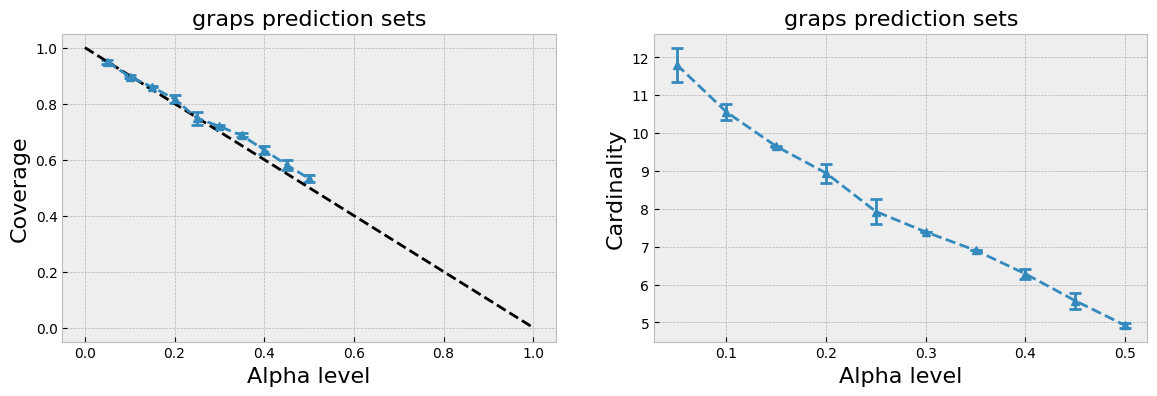

In [142]:

fontsize=16
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].errorbar(
    alpha, graps_coverage_mean, yerr=graps_coverage_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[0].plot([0, 1], [1, 0], '--', c='k', label='Marginal Coverage')
ax[0].set_title('graps prediction sets', fontsize=fontsize)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, graps_cardinality_mean, yerr=graps_cardinality_std, 
    marker='^', ls='--', capthick=2, capsize=4,
)
ax[1].set_title('graps prediction sets', fontsize=fontsize)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.show()

### Overall comparison

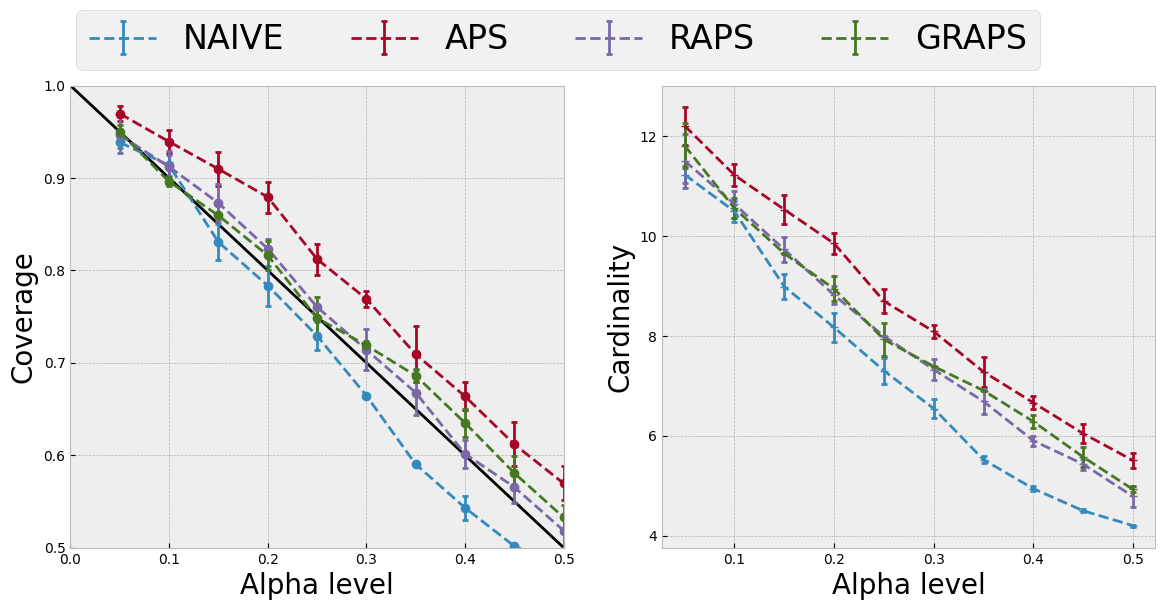

In [144]:
capsize = 2
fontsize=20
capthick=2
lw = 2
marker='o'
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))
ax[0].set_xlim(0, 0.5)
ax[0].set_ylim(0.5, 1)
ax[0].plot([1, 0], [0, 1], c='k', label='Ideal Coverage')
ax[0].errorbar(
    alpha, naive_coverage_mean, yerr=naive_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='NAIVE',
)
ax[0].errorbar(
    alpha, aps_coverage_mean, yerr=aps_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='APS',
)
ax[0].errorbar(
    alpha, raps_coverage_mean, yerr=raps_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='RAPS',
)
ax[0].errorbar(
    alpha, graps_coverage_mean , yerr=graps_coverage_std, lw=lw,
    marker=marker, ls='--', capthick=capthick, capsize=capsize, label='GRAPS',
)
ax[0].set_xlabel('Alpha level', fontsize=fontsize)
ax[0].set_ylabel('Coverage', fontsize=fontsize)

ax[1].errorbar(
    alpha, naive_cardinality_mean, yerr=naive_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='NAIVE',
)
ax[1].errorbar(
    alpha, aps_cardinality_mean, yerr=aps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='APS',
)
ax[1].errorbar(
    alpha, raps_cardinality_mean, yerr=raps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='RAPS',
)
ax[1].errorbar(
    alpha, graps_cardinality_mean , yerr=graps_cardinality_std, lw=lw,
    marker='_', ls='--', capthick=capthick, capsize=capsize, label='GRAPS',
)
ax[1].set_xlabel('Alpha level', fontsize=fontsize)
ax[1].set_ylabel('Cardinality', fontsize=fontsize)
plt.legend(fontsize=fontsize + 4, bbox_to_anchor=(0.8, 1.2), ncol=5)
plt.savefig(fig_dir / 'sets-compare.png')
plt.show()

### Subgroup comparison

In [115]:
alpha, naive_subgroup_coverage_mean, naive_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_dfs, prefix='naive'
)
alpha, naive_subgroup_cardinality_mean, naive_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_dfs, prefix='naive'
)
alpha, aps_subgroup_coverage_mean, aps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_dfs, prefix='aps'
)
alpha, aps_subgroup_cardinality_mean, aps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_dfs, prefix='aps'
)
alpha, raps_subgroup_coverage_mean, raps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_dfs, prefix='raps'
)
alpha, raps_subgroup_cardinality_mean, raps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_dfs, prefix='raps'
)
alpha, graps_subgroup_coverage_mean, graps_subgroup_coverage_std = aggregate_coverage_subgroup(
    test_dfs, prefix='graps'
)
alpha, graps_subgroup_cardinality_mean, graps_subgroup_cardinality_std = aggregate_cardinality_subgroup(
    test_dfs, prefix='graps'
)

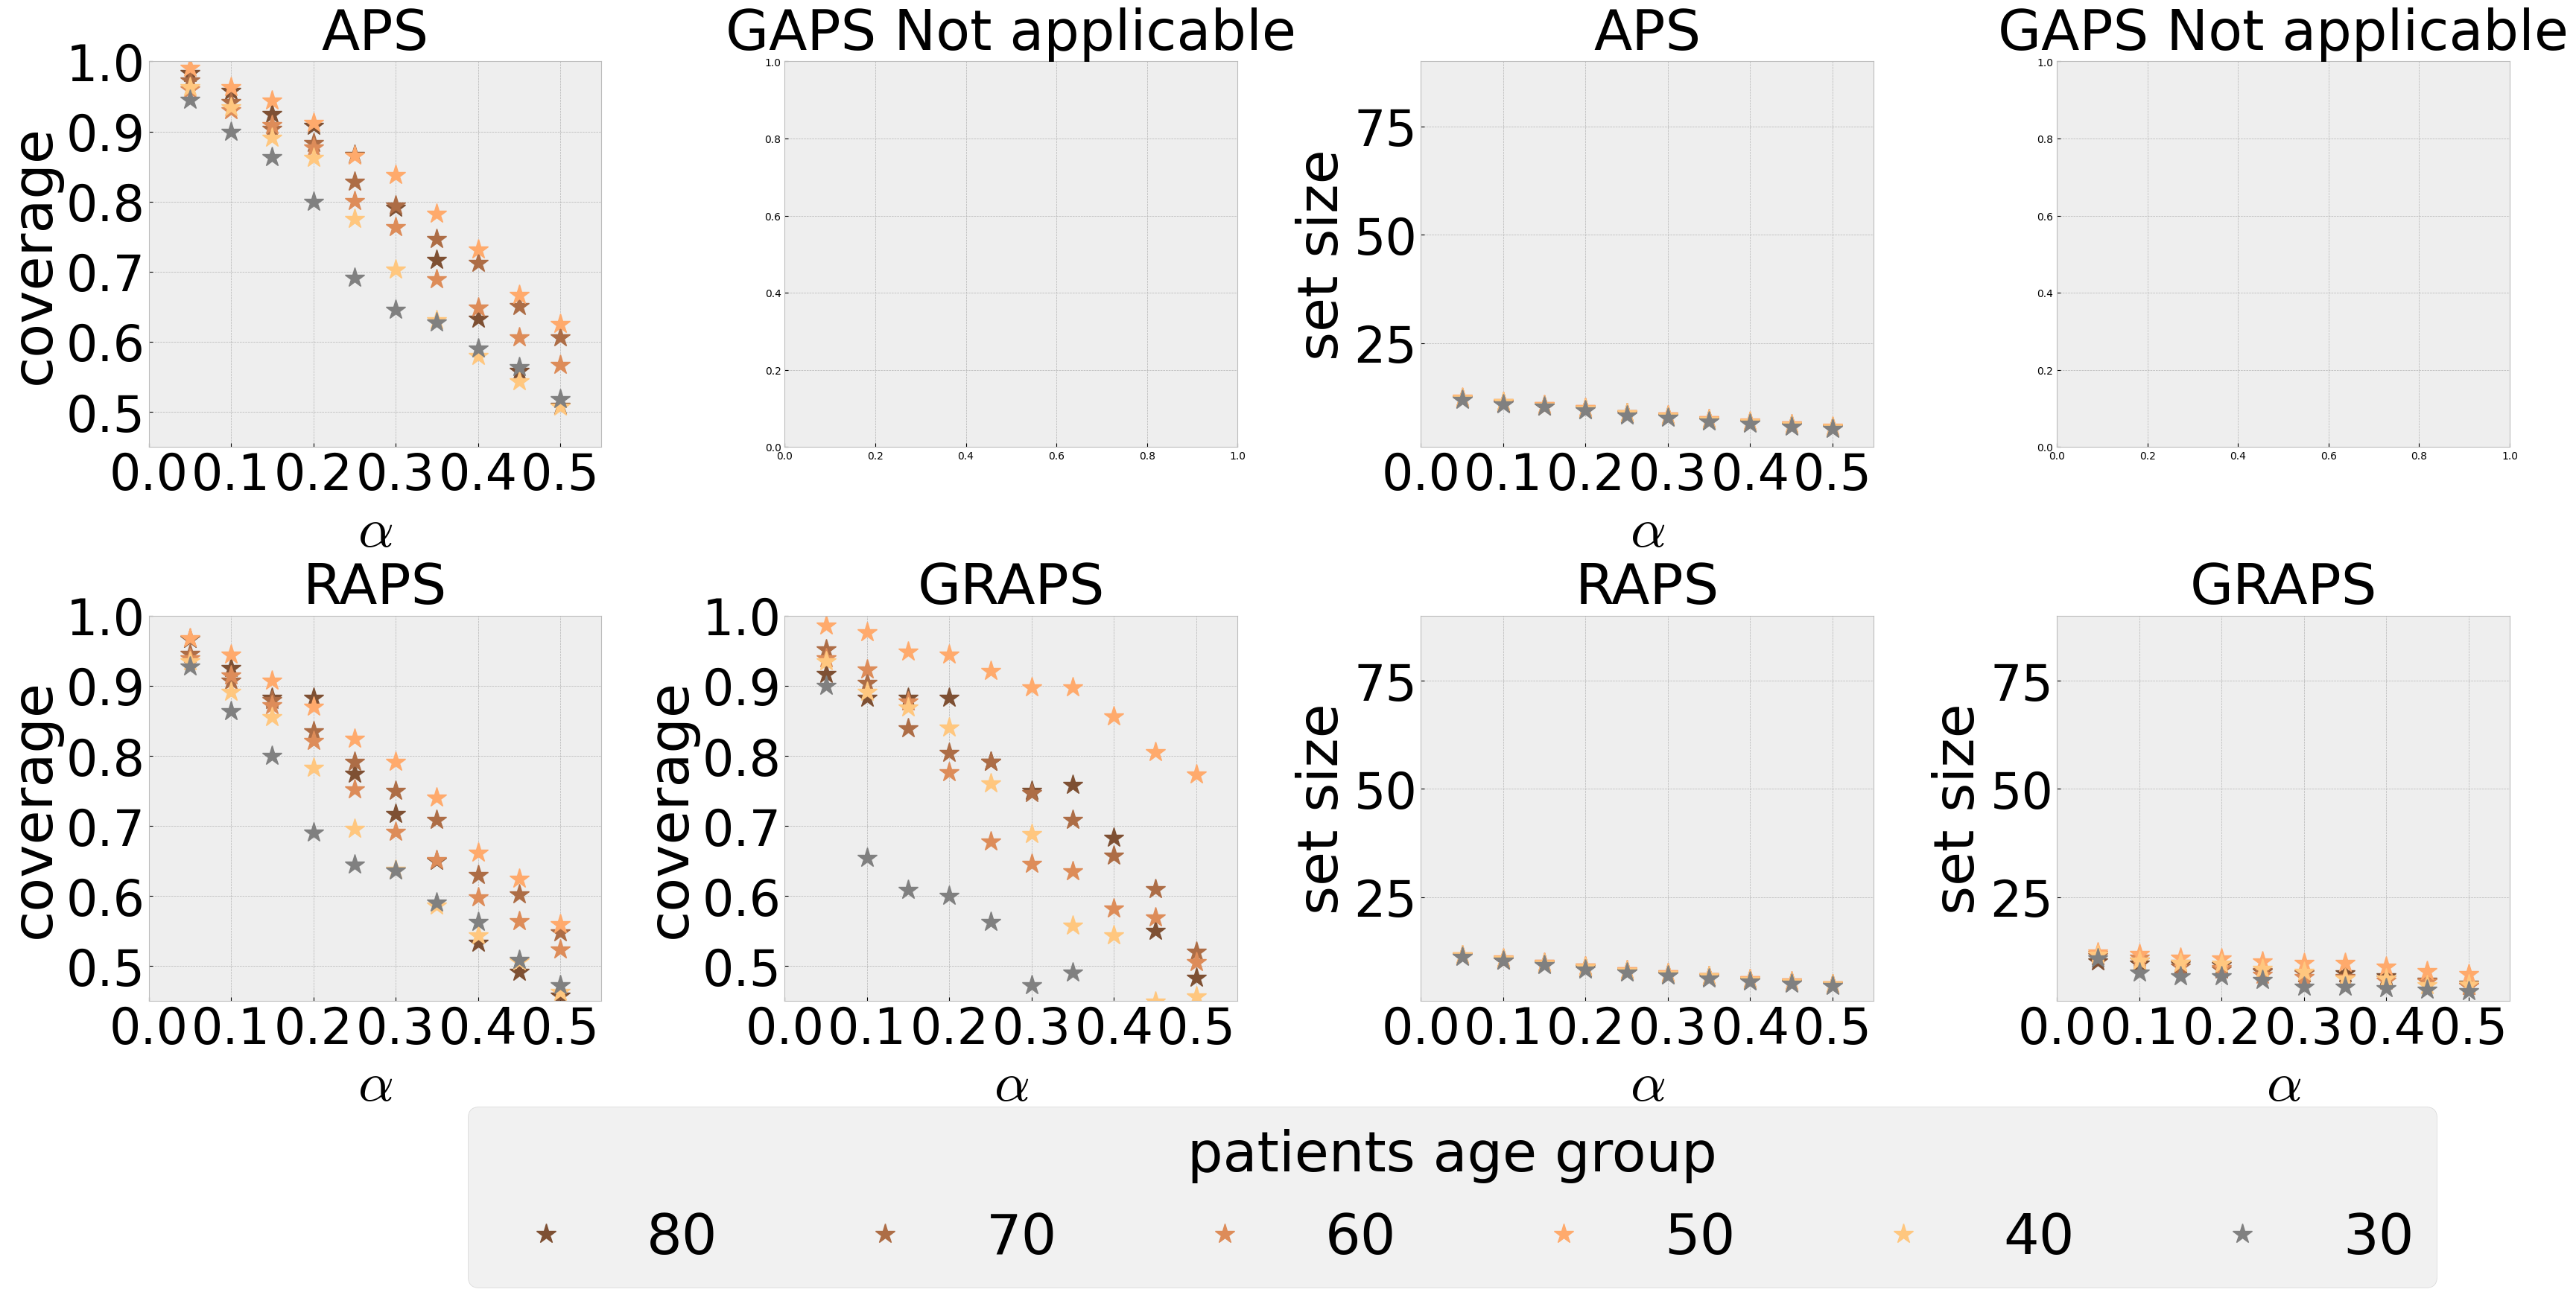

In [136]:
fontsize=54
labelsize=48
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(34, 18), sharex=False, sharey=False)
ls=''
lw=6
marker = '^'
ms = 20
alpha=1.0
xticks = np.arange(0.0, 0.51, 0.1)
yticks = np.arange(0.5, 1.01, 0.1)
xlim = (0, 0.55)
ylim = (0.45, 1.0)


# ax[0, 0].plot([0.1, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(aps_subgroup_coverage_mean.items()):
    ax[0, 0].plot(ALPHAS, v, label=f'{"30" if k == 0 else (k + 3) * 10}', ls=ls, lw=lw, alpha=alpha, marker='*', ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
# ax[0, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[0, 0].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[0, 0].set_title('APS', fontsize=fontsize )
ax[0, 0].set_xlim(*xlim)
ax[0, 0].set_ylim(*ylim)
ax[0, 0].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[0, 0].set_ylabel('coverage', fontsize=fontsize)
ax[0, 0].set_xticks(xticks)
ax[0, 0].set_yticks(yticks)
ax[0, 0].tick_params(axis='x', labelsize=labelsize)
ax[0, 0].tick_params(axis='y', labelsize=labelsize)


ax[0, 1].set_title('GAPS Not applicable', fontsize=fontsize )

# ax[1, 0].plot([0.1, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(raps_subgroup_coverage_mean.items()):
    ax[1, 0].plot(ALPHAS, v, label=f'{"30" if k == 0 else (k + 3) * 10}', ls=ls, lw=lw, alpha=alpha, marker='*', ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
# ax[1, 0].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 0].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[1, 0].set_title('RAPS', fontsize=fontsize)
ax[1, 0].set_xlim(*xlim)
ax[1, 0].set_ylim(*ylim)
ax[1, 0].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1, 0].set_ylabel('coverage', fontsize=fontsize)
ax[1, 0].set_xticks(xticks)
ax[1, 0].set_yticks(yticks)
ax[1, 0].tick_params(axis='x', labelsize=labelsize)
ax[1, 0].tick_params(axis='y', labelsize=labelsize)

# ax[1, 1].plot([0, 1], [1, 0], '--', c='k')
for i, (k, v) in enumerate(graps_subgroup_coverage_mean.items()):
    ax[1, 1].plot(ALPHAS, v, label=f'{"30" if k == 0 else (k + 3) * 10}', ls=ls, lw=lw, alpha=alpha, marker='*', ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
# ax[1, 1].axvline(x=0.05, color="black", linestyle='--', lw=lw)
# ax[1, 1].text(0.08, 0.11, '95% confidence level', rotation=0, fontsize=fontsize)
ax[1, 1].set_title('GRAPS', fontsize=fontsize)
ax[1, 1].set_xlim(*xlim)
ax[1, 1].set_ylim(*ylim)
ax[1, 1].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1, 1].set_ylabel('coverage', fontsize=fontsize)
ax[1, 1].set_xticks(xticks)
ax[1, 1].set_yticks(yticks)
ax[1, 1].tick_params(axis='x', labelsize=labelsize )
ax[1, 1].tick_params(axis='y', labelsize=labelsize)

xticks = np.arange(0.0, 0.6, 0.1)
yticks = np.arange(0, 1.1, 0.1)
xlim = (0, 0.55)
ylim = (1, 90)

for i, (k, v) in enumerate(aps_subgroup_cardinality_mean.items()):
    ax[0, 2].plot(ALPHAS, v, label=f'{"30" if k == 0 else (k + 3) * 10}', ls=ls, lw=lw, alpha=alpha, marker='*', ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
ax[0, 2].set_xlim(*xlim)
ax[0, 2].set_ylim(*ylim)
ax[0, 2].set_title('APS', fontsize=fontsize )
ax[0, 2].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[0, 2].set_ylabel('set size', fontsize=fontsize)
ax[0, 2].set_xticks(xticks)
ax[0, 2].tick_params(axis='x', labelsize=labelsize)
ax[0, 2].tick_params(axis='y', labelsize=labelsize)

for i, (k, v) in enumerate(raps_subgroup_cardinality_mean.items()):
    ax[1, 2].plot(ALPHAS, v, label=f'{"30" if k == 0 else (k + 3) * 10}', ls=ls, lw=lw, alpha=alpha, marker='*', ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
ax[1, 2].set_xlim(*xlim)
ax[1, 2].set_ylim(*ylim)
ax[1, 2].set_title('RAPS', fontsize=fontsize )
ax[1, 2].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1, 2].set_ylabel('set size', fontsize=fontsize)
ax[1, 2].set_xticks(xticks)
ax[1, 2].tick_params(axis='x', labelsize=labelsize)
ax[1, 2].tick_params(axis='y', labelsize=labelsize)

# ax[0, 3].set_xlim(*xlim)
# ax[0, 3].set_ylim(*ylim)
ax[0, 3].set_title('GAPS Not applicable', fontsize=fontsize )
# ax[0, 3].set_xlabel(r'$\alpha$', fontsize=fontsize)
# ax[0, 3].set_ylabel('set size', fontsize=fontsize)
# ax[0, 3].set_xticks(xticks)
# ax[0, 3].tick_params(axis='x', labelsize=labelsize)
# ax[0, 3].tick_params(axis='y', labelsize=labelsize)

for i, (k, v) in enumerate(graps_subgroup_cardinality_mean.items()):
    ax[1, 3].plot(ALPHAS, v, label=f'{"30" if k == 0 else (k + 3) * 10}', ls=ls, lw=lw, alpha=alpha, marker='*', ms=ms, c='gray' if k == 0 else SKIN_COLORS[k-1])
ax[1, 3].set_xlim(*xlim)
ax[1, 3].set_ylim(*ylim)
ax[1, 3].set_title('GRAPS', fontsize=fontsize )
ax[1, 3].set_xlabel(r'$\alpha$', fontsize=fontsize)
ax[1, 3].set_ylabel('set size', fontsize=fontsize)
ax[1, 3].set_xticks(xticks)
ax[1, 3].tick_params(axis='x', labelsize=labelsize)
ax[1, 3].tick_params(axis='y', labelsize=labelsize)

handles, labels = ax[0, 0].get_legend_handles_labels()


plt.tight_layout(h_pad=4, w_pad=4)
plt.subplots_adjust(bottom=0.25)
plt.legend(
    handles,
    labels,
    title='patients age group', 
    title_fontproperties={
        'style': 'normal',
        'size': fontsize,
    },
    fontsize=fontsize,
    bbox_to_anchor=(0.90, -0.20, 0.0, 0),
    ncol=7,
)

plt.savefig(fig_dir / 'ages-subgroup-coverage.pdf', bbox_inches="tight")
plt.show()